In [1]:
import pyvista as pv
import numpy as np
from scipy.spatial.distance import cdist
from scipy.spatial import ConvexHull
from shapely import Polygon
from geopandas import GeoDataFrame
from multiview_mapping_toolkit.cameras.cameras import PhotogrammetryCameraSet
from multiview_mapping_toolkit.meshes.meshes import TexturedPhotogrammetryMesh
from scipy.spatial.transform import Rotation

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_non_overlapping_points(
    n_points, distance_thresh=1, size=10, random_seed=None
):
    np.random.seed(random_seed)
    all_points = (np.random.rand(1, 2) - 0.5) * size
    while all_points.shape[0] < n_points:
        new_point = (np.random.rand(1, 2) - 0.5) * size

        dist_from_existing = cdist(new_point, all_points)
        if np.min(dist_from_existing) > distance_thresh:
            all_points = np.concatenate((all_points, new_point), axis=0)

    return all_points


def extract_polygon(mesh: pv.PolyData):
    xy_points = mesh.points[:, :2]
    hull = ConvexHull(xy_points)
    return Polygon(xy_points[hull.vertices])


def make_color_gradient(color, number):
    repeated_colors = np.tile(color, (number, 1))
    brightness = np.expand_dims(np.linspace(0.5, 1, number), 1)
    scaled_colors = repeated_colors * brightness
    return scaled_colors


def create_scene_mesh(
    box_centers=(),
    cylinder_centers=(),
    cone_centers=(),
    cylinder_radius=0.5,
    cone_radius=0.5,
    box_size=1 / np.sqrt(2.0),
    grid_size=(20, 20),
    add_ground=True,
):
    box_meshes = []
    box_polygons = []
    ID = 0.0
    for x, y in box_centers:
        x_min = x - box_size / 2.0
        x_max = x + box_size / 2.0
        y_min = y - box_size / 2.0
        y_max = y + box_size / 2.0

        box = pv.Box((x_min, x_max, y_min, y_max, 0, box_size), quads=False)
        box["ID"] = np.full(box.n_cells, fill_value=ID)
        box_meshes.append(box)
        box_polygons.append(extract_polygon(box))
        ID += 1.0

    cylinder_meshes = []
    cylinder_polygons = []
    for x, y in cylinder_centers:
        cylinder = pv.Cylinder(
            (x, y, 0.5), direction=(0, 0, 1), radius=cylinder_radius, resolution=10
        ).triangulate()
        cylinder["ID"] = np.full(cylinder.n_cells, fill_value=ID)
        cylinder_meshes.append(cylinder)
        cylinder_polygons.append(extract_polygon(cylinder))
        ID += 1.0

    cone_meshes = []
    cone_polygons = []
    for x, y in cone_centers:
        cone = pv.Cone(
            (x, y, 0.5),
            direction=(0, 0, -1),
            radius=cone_radius,
            resolution=12,
        ).triangulate()
        cone["ID"] = np.full(cone.n_cells, fill_value=ID)
        cone_meshes.append(cone)
        cone_polygons.append(extract_polygon(cone))
        ID += 1.0

    merged_mesh = pv.merge(box_meshes + cylinder_meshes + cone_meshes)
    labels_gdf = GeoDataFrame(
        {
            "name": ["cube"] * len(box_meshes)
            + ["cylinder"] * len(cylinder_meshes)
            + ["cone"] * len(cone_meshes)
        },
        geometry=box_polygons + cylinder_polygons + cone_polygons,
    )

    if add_ground:
        # Add the ground plane
        object_points = merged_mesh.points[np.isclose(merged_mesh.points[:, 2], 0)]
        grid_size_x, grid_size_y = grid_size
        # Add the corner points of the ground plane
        grid = np.meshgrid(np.linspace(-grid_size_x/2, grid_size_x/2, num=100), np.linspace(-grid_size_y/2, grid_size_y/2, num=100))
        grid = [x.flatten() for x in grid]
        ground_points = np.vstack(grid + [np.zeros_like(grid[0])]).T
        
        ground_points = pv.PolyData(ground_points)
        object_points = pv.PolyData(object_points)
        combined = object_points + ground_points
        # Triangulate between all the vertices
        ground_surf = (combined).delaunay_2d()
        # Set the ID to nan
        ground_surf["ID"] = np.full(ground_surf.n_cells, fill_value=np.nan)
        # Merge the ground plane with the other actors
        merged_mesh = merged_mesh + ground_surf
    return merged_mesh, labels_gdf

In [3]:
points = create_non_overlapping_points(n_points=15, random_seed=42)

mesh, labels_gdf = create_scene_mesh(
    box_centers=points[:5],
    cylinder_centers=points[5:10],
    cone_centers=points[10:],
    add_ground=True,
)

<Axes: >

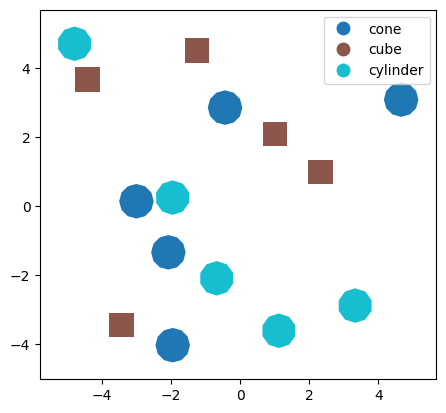

In [4]:
labels_gdf.plot("name", legend=True)

# Create the colors

In [5]:
color_dict = {"cube": (1, 0, 0), "cone": (0, 1, 0), "cylinder": (0, 0, 1)}

colors_per_face = np.full((mesh.n_cells, 3), fill_value=0.5)

for name, group in labels_gdf.groupby("name"):
    num = len(group)
    gradient = make_color_gradient(color_dict[name], num)
    # Indices into the original dataset
    IDs = group.index.to_numpy()
    # TODO rename
    for ID, color in zip(IDs, gradient):
        matching = mesh["ID"] == ID
        colors_per_face[matching, :] = color


# Create a set of virtual cameras

In [6]:
HEIGHT = 15
DIST_FROM_CENTER = 10
PITCH = 150

t_vecs = (
    (0, 0, HEIGHT),
    (0, DIST_FROM_CENTER, HEIGHT),
    (DIST_FROM_CENTER, 0, HEIGHT),
    (-DIST_FROM_CENTER, 0, HEIGHT),
    (0, -DIST_FROM_CENTER, HEIGHT),
)
# Roll, pitch, yaw convention
r_vecs = ((0, 180, 0), (0, PITCH, 0), (270, PITCH, 0), (90, PITCH, 0), (180, PITCH, 0))

cam_to_world_transforms = []
for r_vec, t_vec in zip(r_vecs, t_vecs):
    r_mat = Rotation.from_euler("ZXY", r_vec, degrees=True).as_matrix()
    transform = np.eye(4)
    transform[:3, :3] = r_mat
    transform[:3, 3] = t_vec
    cam_to_world_transforms.append(transform)

INTRINSICS = {0: {"f": 4000, "cx":0, "cy": 0, "image_width":3000, "image_height": 2200}}

camera_set = PhotogrammetryCameraSet(cam_to_world_transforms=cam_to_world_transforms, intrinsic_params_per_sensor_type=INTRINSICS)

# Create a mesh visualization

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


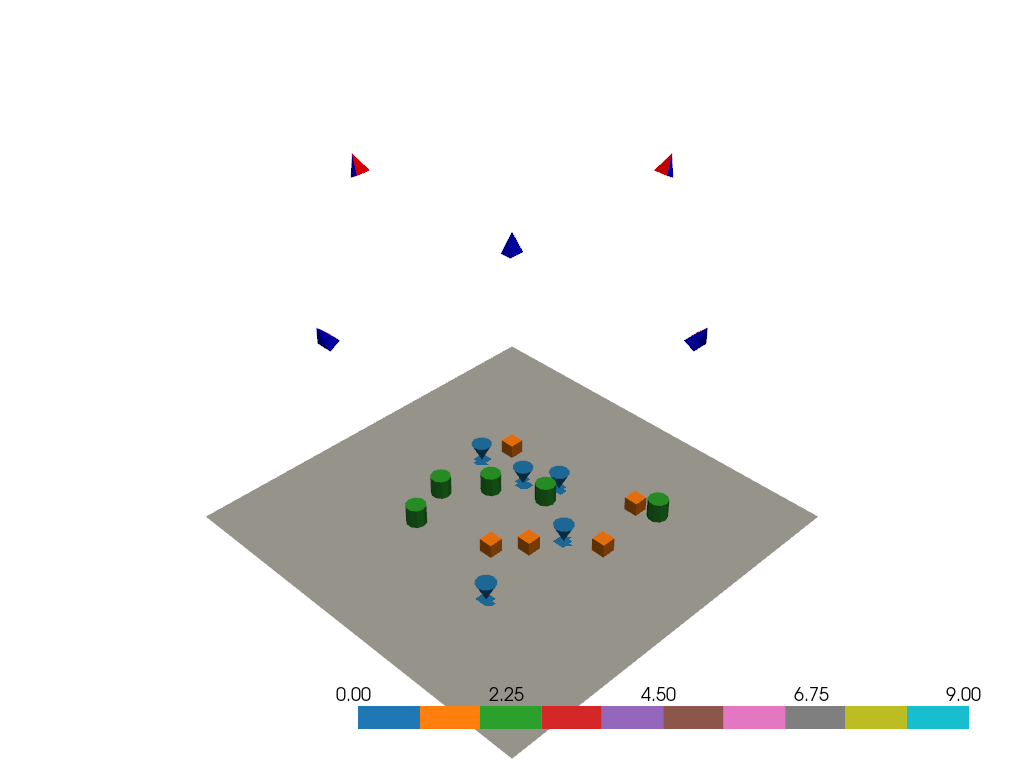

In [7]:
object_class_mesh = TexturedPhotogrammetryMesh(
    mesh, texture=labels_gdf, texture_column_name="name"
)
object_class_mesh.vis(
    force_xvfb=True,
    camera_set=camera_set,
)

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


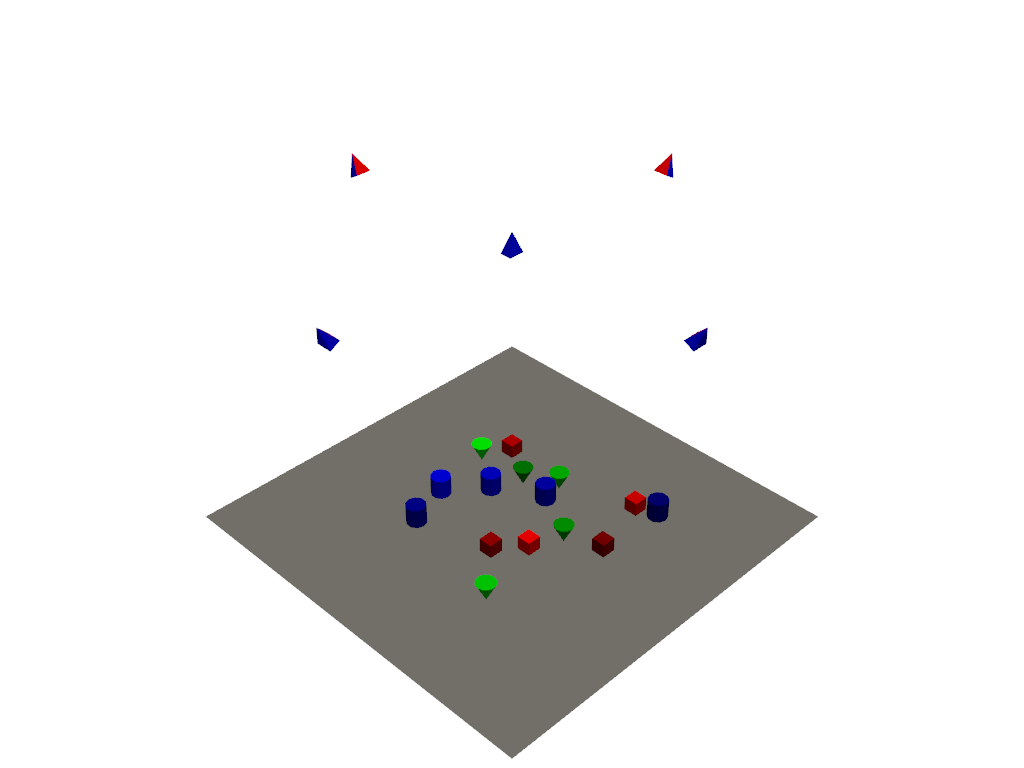

In [8]:
colored_mesh = TexturedPhotogrammetryMesh(mesh, texture=colors_per_face)
colored_mesh.vis(force_xvfb=True, camera_set=camera_set)

/ofo-share/repos-david/conda/envs/MVMT-dev/lib/python3.9/site-packages/pyvista/jupyter/notebook.py:33: UserWarning: Failed to use notebook backend: 

No module named 'trame.ui.vuetify'

Falling back to a static output.
  warnings.warn(


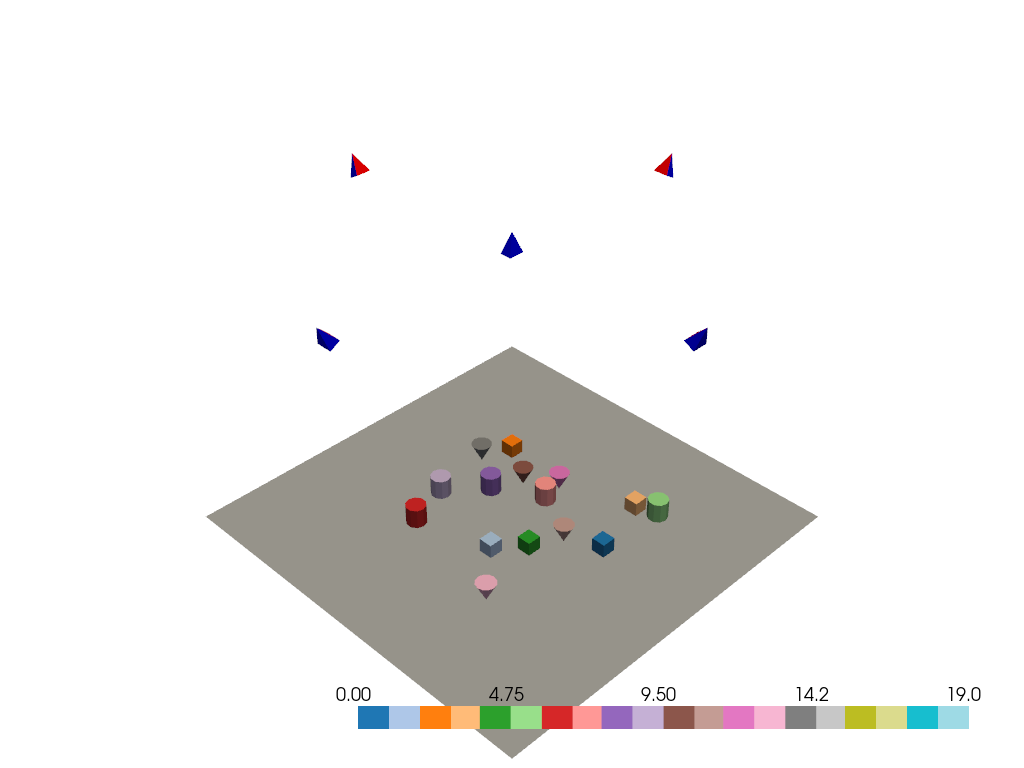

In [9]:
object_ID_mesh = TexturedPhotogrammetryMesh(mesh, texture="ID")
object_ID_mesh.vis(force_xvfb=True, camera_set=camera_set)

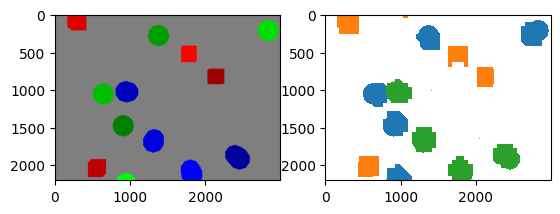

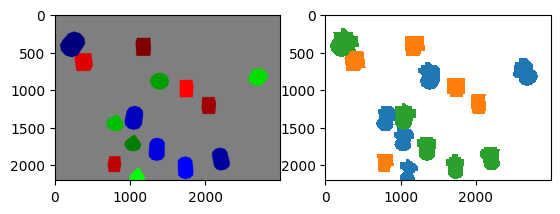

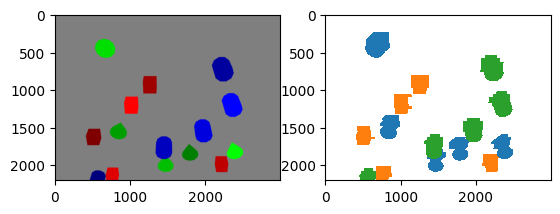

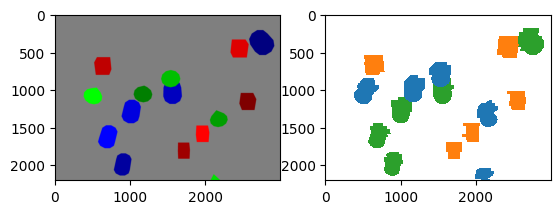

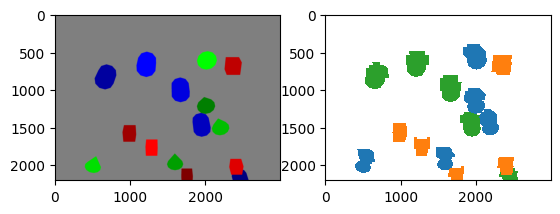

In [11]:
import matplotlib.pyplot as plt

for i in range(5):
    rendered_image = colored_mesh.render_pytorch3d(
        camera_set, i, shade_by_indexing=True
    )
    rendered_object_ID = object_ID_mesh.render_pytorch3d(
        camera_set, i, shade_by_indexing=True
    )
    rendered_object_class = object_class_mesh.render_pytorch3d(
        camera_set, i, shade_by_indexing=True, 
    )
    rendered_object_class[rendered_object_class == -1] = np.nan
    
    f, axs = plt.subplots(1, 2)
    axs[0].imshow(rendered_image)
    
    
    axs[1].imshow(
        rendered_object_class, cmap="tab10", vmin=0, vmax=9, interpolation="none"
    )
    plt.show()